# Тема курсовой: обучение модели классификации для прогнозирования не выполнения долговых обязательств по текущему кредину.

## 1. Подготовка ноутбука

- Подключаем библиотеки

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inlinebackend.figure_format = 'svg'

from scipy.stats import shapiro, ttest_rel, chi2_contingency

from sklearn.metrics import r2_score as r2, mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

- Формируем пути до данных

In [2]:
PATH_TO_TRAIN = 'course_project_train.csv'
PATH_TO_TEST = 'course_project_test.csv'

## 2. Анализ датасетов

##### Функции для анализа

In [3]:
def missing_data(df: pd.DataFrame) -> pd.Series:
    """get dataframe and calculate emissions in its data in percentage"""
    
    featur_counts = df.count()
    object_counts = df.shape[0]
    
    calc_procent = (1 - featur_counts/object_counts) * 100
    
    feature_procent = round(calc_procent, 2)
            
    result = {i: f'{v}%' for i, v in feature_procent.items() if v != 0}
    
    return pd.Series(result)

In [4]:
def correlation(
    df: pd.DataFrame, 
    target: str
) -> (print, plt.plot):
    """calculates correlation whith target and plots graph"""
    
    corr_table = df.corr()
    
    result = corr_table.drop([target], axis=0) if target != None else corr_table
    sort_values = result.sort_values(target, ascending=False)*100 if target != None else result
    
    coef = round(sort_values[target], 2)
    
    print(coef)
    
    plt.figure(figsize=(12,4))

    plt.barh(coef.index, coef.values)

    plt.title(f'Correlation with {target}', fontsize=16)
    plt.xlabel('percent', fontsize=14)
    
    plt.grid()

In [5]:
def emission(
    series: pd.Series, 
    val: int = None, 
    cmap: pd.Series = None
) -> (print, plt.plot):
    """
    get series and shop emissions in it, 
    if val then can calculate emissions and is percent
    """
    
    if val != None:
        em = series > val

        print(
            f'Число выбрасов = {em.sum()}\n'
            f'Процент выбрасов = {round(em.sum() / series.shape[0] * 100, 2)}%'
        )
    
    plt.scatter(x=series.index, y=series.values, c=cmap)
    plt.show()

In [6]:
def comparison(df, columns):
    
    sort_data = df[columns].sort_values(by=columns[0])
    result = sort_data.reset_index(drop=True)
    
    mmscaler = MinMaxScaler()
    mmscaler.fit(result)
    
    matrix = mmscaler.transform(result)
    
    plt.plot(matrix[:,1])
    plt.plot(matrix[:,0])
    plt.show()

In [7]:
def chi2_test(df, target, feature, values, alpha=0.05):
    
    df = df[df[feature].notna()][:1000]

    df1 = df[df[feature] == values[0]]
    test1 = df1[target].value_counts()

    df2 = df[df[feature] == values[1]]
    test2 = df2[target].value_counts()
    
    p = chi2_contingency([test1, test2])[1]
    print(f'p = {p}')
    
    if p <= alpha:
        print(f'{values[0]} != {values[1]}, при alpha = {alpha}') 
    elif p > alpha:
        print(f'{values[0]} == {values[1]}, при alpha = {alpha}')

In [8]:
def shapiro_test(
    feature: pd.Series,
    alpha: float = 0.05
) -> print:
    
    result = shapiro(feature[:1000])
    
    p = result[1]
    print(f'p = {p}')
    
    if p <= alpha:
        print(f'не имеет нормального распредение при alpha = {alpha}')
    elif p > alpha:
        print(f'имеет нормального распредение при alpha = {alpha}')

In [9]:
def evaluation_pred(true, pred):
    
    print(f'R2 = {round(r2(true, pred), 3)}')

    plt.scatter(true, pred)
    plt.xlabel('True')
    plt.ylabel('Prediction')

##### Описание датасета

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

##### Train

In [10]:
Xy_train = pd.read_csv(PATH_TO_TRAIN)
Xy_train.head(2)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1


- Состояние данных

In [11]:
Xy_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

Видно что в некоторых фичах есть __пропуски__<br>
- Просмотрим их целостность в __процентнах__:

In [12]:
missing_data(df=Xy_train)

Annual Income                   20.76%
Years in current job             4.95%
Months since last delinquent    54.41%
Bankruptcies                     0.19%
Credit Score                    20.76%
dtype: object

Видно что в некоторых фичах отсутствует __очень большое__ количество данных, от 5% до 54,5%
- Просмотрим сводку

In [13]:
Xy_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


- Посмотрим __корреляцию__ с таргером

Credit Score                    44.21
Number of Open Accounts          2.89
Tax Liens                        2.44
Number of Credit Problems        2.01
Monthly Debt                     1.85
Months since last delinquent     0.26
Bankruptcies                     0.16
Maximum Open Credit             -1.43
Current Credit Balance          -1.95
Years of Credit History         -2.06
Annual Income                  -10.14
Current Loan Amount            -22.65
Name: Credit Default, dtype: float64


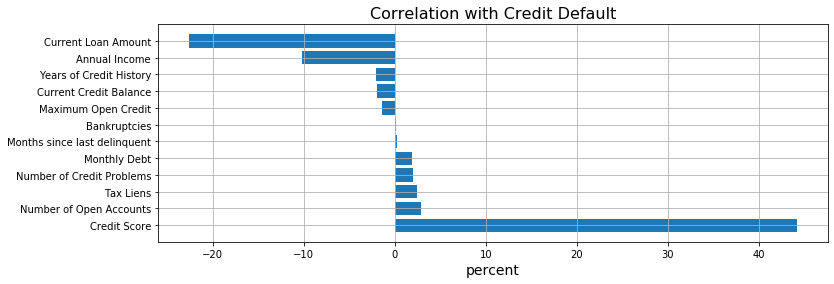

In [14]:
correlation(df=Xy_train, target='Credit Default')

- Наибольшая __прямая зависимость__ с таргером наблюдается у _Credit Score_ = 44%<br>

(Скорее всего это __выбросы__, так как высокий __рейтинг__ не может совпадать с __не выполнением__ кредитвых обязательств.)

- Наибольшая __обратная зависимость__ наблюдается у _Current Load Amount_ = -23%<br> 

(Т.е. __высокий доход__ совпадает с __надежностью клиента__ по выполнению кредитных обязательств.)

##### Final

In [15]:
X_final = pd.read_csv(PATH_TO_TEST)
X_final.head(2)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0


- Состояние данных

In [16]:
X_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
Home Ownership                  2500 non-null object
Annual Income                   1987 non-null float64
Years in current job            2414 non-null object
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    1142 non-null float64
Bankruptcies                    2497 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    1987 non-null float64
dtypes: float64(12), object(4)
me

Видно что в некоторых фичах есть __пропуски__<br>
- Просмотрим их __процентное__ соотношение:

In [17]:
missing_data(df=X_final)

Annual Income                   20.52%
Years in current job             3.44%
Months since last delinquent    54.32%
Bankruptcies                     0.12%
Credit Score                    20.52%
dtype: object

Так же как и в train видно, что в некоторых фичах отсутствует __очень большое__ количество данных, от 3,5% до 54%

In [18]:
X_final.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


## 3. Обработка данных

##### Класс для предобработки данных

In [19]:
class Preprocessing:
    
    def __init__(self, df):
        
        self.df = df
        
    def MSLDmissing(self):
        
        df = self.df
        
        df.loc[df['Months since last delinquent'].isna(), 'Months since last delinquent'] =\
            (df['Months since last delinquent'].isna()).sum()
        
    def YICJretype(self):
    
        df = self.df
        
        years = {'10+ years': 10, '2 years': 2, '3 years': 3, '< 1 year': 0, '5 years': 5, 
                 '1 year': 1, '4 years': 4, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9}

        df['Years in current job - float'] = df['Years in current job'].map(years).astype(float)
        
    def HOretype(self):
        
        df = self.df
    
        df['Home Ownership - float'] = df['Home Ownership'].map(df['Home Ownership'].value_counts()).astype(float)
        
    def PurposeRetype(self):
        
        df = self.df
        
        df['Purpose - float'] = df['Purpose'].map(df['Purpose'].value_counts()).astype(float)
        
    def TermRetype(self):
        
        df = self.df
        
        df['Term - float'] = df['Term'].map(df['Term'].value_counts()).astype(float)
        
    def CSemissions(self):
        
        df = self.df
        
        df.loc[df['Credit Score']>999, 'Credit Score'] =\
            df.loc[df['Credit Score']>999, 'Credit Score'] / 10
        
    def CLAemission(self):
        
        df = self.df
        
        df.loc[df['Current Loan Amount'] < 2e7, 'CLAexception'] = 0
        df.loc[df['Current Loan Amount'] > 2e7, 'CLAexception'] = 1
        
    def pipline(self):
        
        self.MSLDmissing()
        self.YICJretype()
        self.HOretype()
        self.PurposeRetype()
        self.TermRetype()
        self.CSemissions()
        self.CLAemission()

In [20]:
xy_train_prep = Preprocessing(df=Xy_train)

### Приведение типов

- Поменяем тип признаков: __Years in current job, Home Ownership, Purpose, Term__, из object в float

In [21]:
xy_train_prep.YICJretype()
xy_train_prep.HOretype()
xy_train_prep.PurposeRetype()
xy_train_prep.TermRetype()

- Просмотрим как изменилась __корреляция__ с таргетом после приведения типов

Credit Score                    44.21
Number of Open Accounts          2.89
Tax Liens                        2.44
Number of Credit Problems        2.01
Monthly Debt                     1.85
Months since last delinquent     0.26
Bankruptcies                     0.16
Years in current job - float    -0.44
Maximum Open Credit             -1.43
Purpose - float                 -1.55
Current Credit Balance          -1.95
Years of Credit History         -2.06
Home Ownership - float          -2.44
Annual Income                  -10.14
Term - float                   -18.15
Current Loan Amount            -22.65
Name: Credit Default, dtype: float64


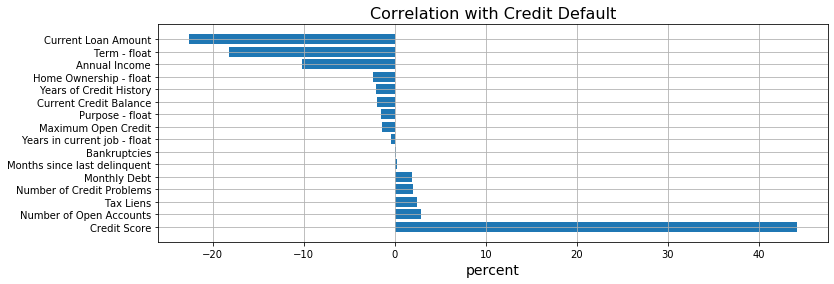

In [22]:
correlation(df=Xy_train, target='Credit Default')

Видно что проявилась __обратная корреляция__ по таким признакам как:

- Количество лет на текущем месте работы = -0.44%
- Домовладение = -2.44%
- Цель кредита = -1.55%
- Срок кредита = -18.15%

### Проверка гипотез

##### Нормальность

- Просмотрим график __Annual Income__

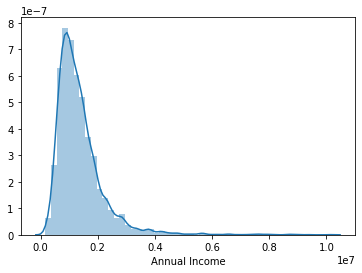

In [23]:
annInc = Xy_train[Xy_train['Annual Income'].notna()]['Annual Income']

sns.distplot(annInc)
plt.show()

$H_0 -$ __Annual Income__ имеет нормальное распределение <br>
$H_1 \neq H_0 -$ __Annual Income__ не имеет нормального распределения

In [24]:
shapiro_test(
    feature=annInc,
    alpha=0.5
)

p = 1.8844925930263994e-32
не имеет нормального распредение при alpha = 0.5


$H_1 \neq H_0 - H_0$ опровергнута

- Просмотрим график __Maximum Open Credit__

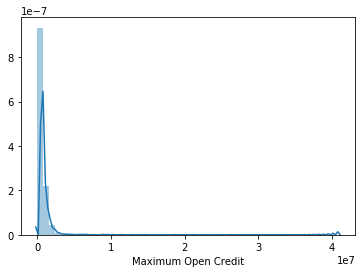

In [25]:
maxOpenC= Xy_train[Xy_train['Maximum Open Credit'] < 5e7]['Maximum Open Credit']

sns.distplot(maxOpenC)
plt.show()

$H_0 -$ __Maximum Open Credit__ имеет нормальное распределение <br>
$H_1 \neq H_0 -$ __Maximum Open Credit__ не имеет нормального распределения

In [26]:
shapiro_test(
    feature=maxOpenC,
    alpha=0.5
)

p = 1.401298464324817e-45
не имеет нормального распредение при alpha = 0.5


$H_1 \neq H_0 - H_0$ опровергнута

- Просмотрим график __Current Loan Amount__

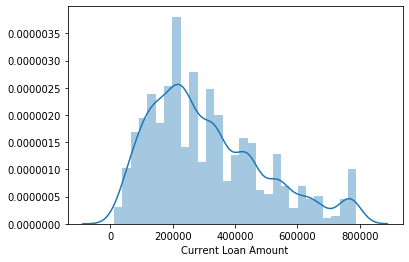

In [27]:
currLoanAm = Xy_train[Xy_train['Current Loan Amount'] < 1e7]['Current Loan Amount']

sns.distplot(currLoanAm)
plt.show()

$H_0 -$ __Current Loan Amount__ имеет нормальное распределение<br>
$H_1 \neq H_0 -$ __Current Loan Amount__ не имеет нормального распределения

In [28]:
shapiro_test(
    feature=currLoanAm,
    alpha=0.5
)

p = 1.9021480243577165e-20
не имеет нормального распредение при alpha = 0.5


$H_1 \neq H_0 - H_0$ опровергнута

- Просмотрим график __Monthly Debt__

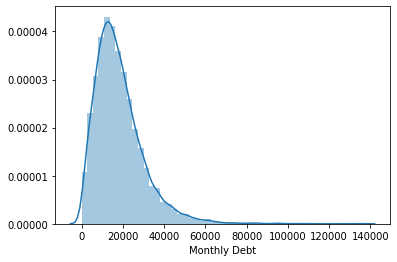

In [29]:
mountlyD = Xy_train['Monthly Debt']

sns.distplot(mountlyD)
plt.show()

$H_0 -$ __Monthly Debt__ имеет нормальное распределение<br>
$H_1 \neq H_0 -$ __Monthly Debt__ не имеет нормального распределения

In [30]:
shapiro_test(
    feature=mountlyD,
    alpha=0.5
)

p = 6.993885971736841e-25
не имеет нормального распредение при alpha = 0.5


$H_1 \neq H_0 - H_0$ опровергнута

- Просмотрим график __Credit Score__

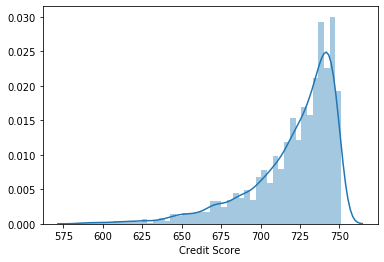

In [31]:
creditScore = Xy_train[
    (Xy_train['Credit Score'].notna()) &
    (Xy_train['Credit Score'] < 1000)
]['Credit Score']

sns.distplot(creditScore)
plt.show()

$H_0 -$ __Credit Score__ имеет нормальное распределение<br>
$H_1 \neq H_0 -$ __Credit Score__ не имеет нормального распределения

In [32]:
shapiro_test(
    feature=creditScore,
    alpha=0.5
)

p = 1.710221728107389e-29
не имеет нормального распредение при alpha = 0.5


$H_1 \neq H_0 - H_0$ опровергнута

##### Синхронность

- 

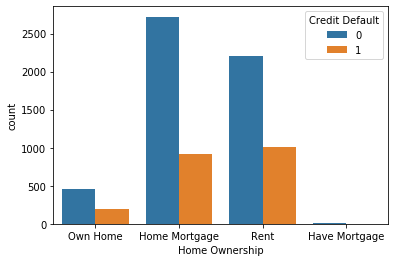

In [33]:
sns.countplot(x='Home Ownership', hue='Credit Default', data=Xy_train)
plt.show()

In [34]:
chi2_test(
    df=Xy_train, 
    target='Credit Default',
    feature='Home Ownership',
    values=['Rent', 'Home Mortgage'],
    alpha=0.05
)

p = 0.028443444105670197
Rent != Home Mortgage, при alpha = 0.05


### Обработка пропусков

In [35]:
missing_data(df=Xy_train)

Annual Income                   20.76%
Years in current job             4.95%
Months since last delinquent    54.41%
Bankruptcies                     0.19%
Credit Score                    20.76%
Years in current job - float     4.95%
dtype: object

- **Months since last delinquent** - количество месяцев с последней просрочки платежа

Судя по большому количеству пропусков в этом признаке можно сделать вывод, что они говорят об __отсутствии просрочек__ по платежу, а значит посчитать количество месяцев не возможно.<br>
Тогда заполним пропуски __числом__, которое будет показывать нам - сколько __всего__ таких пропусков.

In [36]:
xy_train_prep.MSLDmissing()

- **Annual Income** - годовой доход

- **Years in current job** - количество лет на текущем месте работы

- **Bankruptcies** - банкротства

- **Credit Score** - кредитный рейтинг

Просмотрим как изменилась __корреляция__ с таргетом после обработки пропусков

Credit Score                    44.21
Number of Open Accounts          2.89
Tax Liens                        2.44
Number of Credit Problems        2.01
Monthly Debt                     1.85
Bankruptcies                     0.16
Years in current job - float    -0.44
Months since last delinquent    -1.17
Maximum Open Credit             -1.43
Purpose - float                 -1.55
Current Credit Balance          -1.95
Years of Credit History         -2.06
Home Ownership - float          -2.44
Annual Income                  -10.14
Term - float                   -18.15
Current Loan Amount            -22.65
Name: Credit Default, dtype: float64


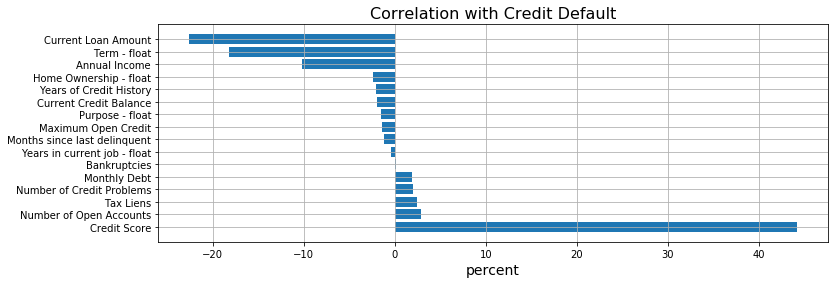

In [37]:
correlation(df=Xy_train, target='Credit Default')

Видно что проявилась __обратная корреляция__ по таким признакам как:
- количество месяцев с последней просрочки платежа = -1.17%

### Обработка выбросов

- **Credit Score** - кредитный рейтинг (max 999)

Число выбрасов = 400
Процент выбрасов = 5.33%


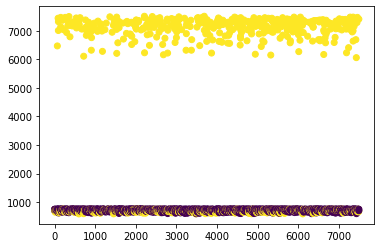

In [38]:
emission(
    series=Xy_train['Credit Score'], 
    val=999, 
    cmap=Xy_train['Credit Default']
)

In [39]:
xy_train_prep.CSemissions()

Число выбрасов = 0
Процент выбрасов = 0.0%


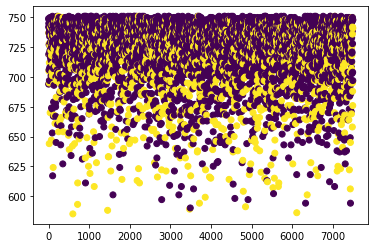

In [40]:
emission(
    series=Xy_train['Credit Score'], 
    val=999, 
    cmap=Xy_train['Credit Default']
)

- **Current Loan Amount** - текущая сумма кредита

Число выбрасов = 870
Процент выбрасов = 11.6%


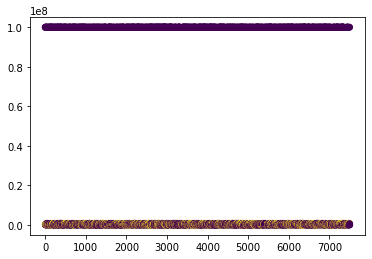

In [41]:
emission(
    series=Xy_train['Current Loan Amount'],
    val=2e7,
    cmap=Xy_train['Credit Default']
)

In [42]:
xy_train_prep.CLAemission()

- **Maximum Open Credit** - максимальная сумма кредита

Число выбрасов = 3
Процент выбрасов = 0.04%


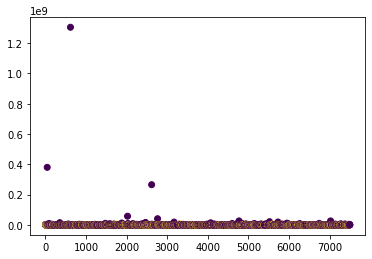

In [43]:
emission(
    series=Xy_train['Maximum Open Credit'],
    val=2e8,
    cmap=Xy_train['Credit Default']
)

Просмотрим как изменилась __корреляция__ с таргетом после обработки выбрасов

Number of Open Accounts          2.89
Tax Liens                        2.44
Number of Credit Problems        2.01
Monthly Debt                     1.85
Bankruptcies                     0.16
Years in current job - float    -0.44
Months since last delinquent    -1.17
Maximum Open Credit             -1.43
Purpose - float                 -1.55
Current Credit Balance          -1.95
Years of Credit History         -2.06
Home Ownership - float          -2.44
Annual Income                  -10.14
Term - float                   -18.15
Credit Score                   -20.72
Current Loan Amount            -22.65
CLAexception                   -22.69
Name: Credit Default, dtype: float64


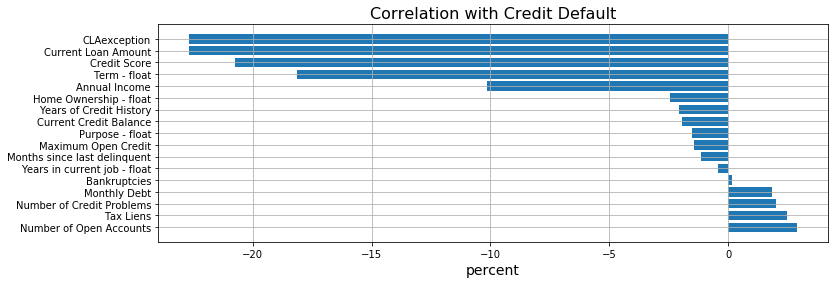

In [44]:
correlation(df=Xy_train, target='Credit Default')

Видно что проявилась __обратная корреляция__ по таким признакам как:

- Кредитный рейтинг = -20.72%